In [1]:
import numpy as np
from scipy.stats import norm, uniform, beta, gamma
import matplotlib.pyplot as plt
import deepdish as dd

# Data

For our observed data, let's use as our parameter the logarithm of the chirp masses from the 44 BBH systems observed in GWTC-2.

$$ \theta_i = \log_{10} \left[M_c \textrm{ for event }i\right]\,,\quad i=1,\ldots,n=44\,. $$

The chirp mass is usually fairly well measured; we will therefore ingnore measurement errors. The median value of the chirp mass calculated from the posterior chain is used as a point estimate for each event.

We will also ignore selection effects; we are modelling the "observed" distribution of chirp masses.

44 events: {'GW150914': 1.4623698088301944, 'GW151012': 1.1906753586542813, 'GW151226': 0.948032277113912, 'GW170104': 1.3414077205227628, 'GW170608': 0.8999128738306943, 'GW170729': 1.5381103668257086, 'GW170809': 1.4012369396193178, 'GW170814': 1.3829745696059013, 'GW170818': 1.4314751720918388, 'GW170823': 1.470349455031628, 'S190408an': 1.2706913112936684, 'S190412m': 1.124418490133878, 'S190413ac': 1.5122816272447128, 'S190413i': 1.39614203473803, 'S190421ar': 1.4971269617757426, 'S190424ao': 1.4824697243198097, 'S190503bf': 1.491924852039218, 'S190512at': 1.1664499182870791, 'S190513bm': 1.3359887403373047, 'S190514n': 1.4590141890539372, 'S190517h': 1.4000297388051404, 'S190519bj': 1.6447752970512888, 'S190521g': 1.794420163549175, 'S190521r': 1.5134394959744055, 'S190527w': 1.3786781415571316, 'S190602aq': 1.69137135656633, 'S190620e': 1.5719591627443952, 'S190630ag': 1.404029749761025, 'S190701ah': 1.6155783356684195, 'S190706ai': 1.631523042622184, 'S190707q': 0.9275454466572

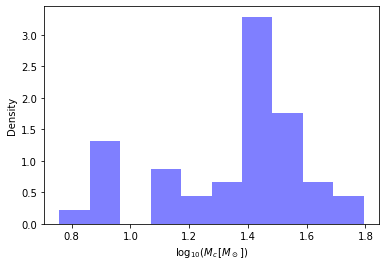

In [2]:
file = "o1o2o3_mass_b_iid_mag_two_comp_iid_tilt_powerlaw_redshift_samples.hdf5"

data = dd.io.load(file)
m1 = data['reweighted']['mass_1']
m2 = data['reweighted']['mass_1']*data['reweighted']['mass_ratio']
Mc = np.median((m1*m2)**(3/5) / (m1+m2)**(1/5), axis=1)

observations = {name:np.log10(Mc[i]) for i, name in enumerate(data['names'])}

n = len(observations)

print(n, "events:", observations)

plt.hist(list(observations.values()), density=True, color='b', alpha=0.5)
plt.xlabel(r"$\log_{10}\left(M_c\,[M_\odot]\right)$"); plt.ylabel('Density');

# DP Density Estimation - fixed $\alpha$ and $H$

Observations $\theta_1,\ldots,\theta_n\sim G$.

Fixed hyperparameters $\alpha=1$ and $H = \mathcal{N}(\mathrm{mean}=1.4,\; \mathrm{stddev}=0.5)$.

DP prior on the distribution,
$ G\sim\mathrm{DP}(\alpha,H)$.

The posterior 
$ P(G|\boldsymbol{\theta}) = \mathrm{DP}\left(n+\alpha, \frac{\alpha H + \sum_{i=1}^{n}\delta_{\theta_i}}{\alpha+n}\right)$.

In [3]:
# How many samples to draw from posterior
N = 1000

# Maximum number of clusters
K = 500

# The observed theta's
obs = np.array(list(observations.values()))

# Fixed hyperparameters for the DP prior
alpha = 10
H = norm(1.4, scale=0.5)

# Stick-breaking construction for the weights...
beta_k = beta(1, alpha+n).rvs(size=(N,K))
pi_k = beta_k.copy()
pi_k[:,1:] = beta_k[:,1:] * (1 - beta_k[:,:-1]).cumprod(axis=1)
    
# ... and the atoms
phi_k = H.rvs(size=(N,K))
mask = np.random.choice([True, False], p=[n/(alpha+n), alpha/(alpha+n)], size=(N,K))
phi_k[mask] = np.random.choice(obs, size=(N,K))[mask]


Because this is a 1-dimensional problem, we can visualise draws from the posterior using the cumulative distribution.

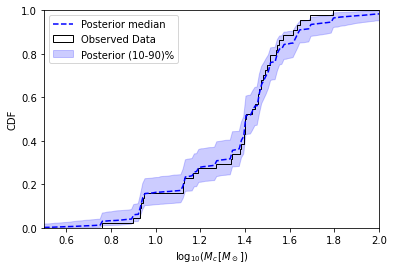

In [4]:
# Compute the CDFs
log10Mc_plot = np.linspace(0.5, 2.5, 200)
sample_cdfs = (pi_k[..., np.newaxis] * np.less.outer(phi_k, log10Mc_plot)).sum(axis=1)
low, mid, up = np.percentile(sample_cdfs, [10, 50, 90], axis=0)
    
# Plotting
fig, ax = plt.subplots()

ax.hist(obs, bins=sorted(obs)+[999], density=True, color='k', 
        histtype='step', cumulative=True, label='Observed Data')

ax.plot(log10Mc_plot, mid, 'b--', label='Posterior median')
ax.fill_between(log10Mc_plot, low, up, color='b', 
                alpha=0.2, label='Posterior (10-90)%')

plt.legend(loc='upper left')
plt.xlim(0.5, 2.)
plt.ylim(0,1)
plt.xlabel(r"$\log_{10}\left(M_c\,[M_\odot]\right)$") 
plt.ylabel('CDF');

# DP Density Estimation - fixed $\alpha$ and $H$

Observations $\theta_1,\ldots,\theta_n\sim G$.

DP prior on the distribution $ G\sim\mathrm{DP}(\alpha,H)$, with $H = \mathcal{N}(\mu,1/\lambda)$.

Priors on the hyperparameters: $\alpha\sim\mathrm{Gamma}(2,5)$, $\mu\sim\mathcal{N}(1,1)$ and $\lambda\sim\mathrm{Gamma}(2,1/4)$.

The posterior is a DP mixture,
$ P(G|\boldsymbol{\theta}) = \int_{0}^{\infty}\mathrm{d}\alpha\;\int_{-\infty}^{\infty}\mathrm{d}\mu\;\int_{0}^{\infty}\mathrm{d}\lambda\;\pi(\alpha)\pi(\mu)\pi(\lambda)\,\mathrm{DP}\left(n+\alpha, \frac{\alpha H + \sum_{i=1}^{n}\delta_{\theta_i}}{\alpha+n}\right)$.

Text(0, 0.5, 'CDF')

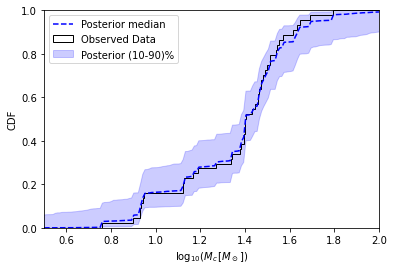

In [5]:
# Number of cluster and posterior draws
N, K = 1000, 500

# Hyperparameter priors
pi_alpha = gamma(2, scale=5)
pi_mu = norm(1.4, scale=0.5)
pi_lam = gamma(2, scale=1/4)

alpha = pi_alpha.rvs(N)
mu = pi_mu.rvs(N)
lam = pi_lam.rvs(N)

# The observed theta's
obs = np.array(list(observations.values()))

# Stick-breaking construction for the weights...
beta_k = np.array([beta(1, a+n).rvs(K) for a in alpha])
pi_k = beta_k.copy()
pi_k[:,1:] = beta_k[:,1:] * (1 - beta_k[:,:-1]).cumprod(axis=1)

# ... and the atoms
phi_k = np.array([norm(m, scale=l).rvs(size=K) for m,l in zip(mu,lam)])
mask = np.array([np.random.choice([True, False], p=[n/(a+n), a/(a+n)], size=K) 
                 for a in alpha])
phi_k[mask] = np.random.choice(obs, size=(N,K))[mask]

# Compute the CDFs
log10Mc_plot = np.linspace(0.5, 2.5, 200)
sample_cdfs = (pi_k[..., np.newaxis] * np.less.outer(phi_k, log10Mc_plot)).sum(axis=1)
low, mid, up = np.percentile(sample_cdfs, [10, 50, 90], axis=0)
    
# Plotting
fig, ax = plt.subplots()

ax.hist(obs, bins=sorted(obs)+[999], density=True, color='k', 
        histtype='step', cumulative=True, label='Observed Data')

ax.plot(log10Mc_plot, mid, 'b--', label='Posterior median')
ax.fill_between(log10Mc_plot, low, up, color='b', 
                alpha=0.2, label='Posterior (10-90)%')

plt.legend(loc='upper left')
plt.xlim(0.5, 2.)
plt.ylim(0,1)
plt.xlabel(r"$\log_{10}\left(M_c\,[M_\odot]\right)$") 
plt.ylabel('CDF')